# kNN
* kNN - распознавание растровых изображений
* kNN- и ODIN-идентификаторы 

In [1]:
import numpy as np

### Функции расстояния между точками
Евклидово расстояние

In [2]:
def euc_dist(x, y):
    return np.sqrt(np.sum((x-y)**2))

Квадрат Евклидова расстояния

In [3]:
def euc_dist_sqr(x, y):
    return np.sum((x-y)**2)

Модульное расстояние

In [4]:
def abs_dist(x, y):
    return np.sum((np.abs(x-y)))

Расстояние Чебышева

In [5]:
def cheb_dist(x, y):
    return np.max((np.abs(x-y)))

### Реализация kNN

Для каждого объекта из тестовой выборки считаем расстояние до всех объектов в обучающей выборке. Выбираем k ближайших и вычисляем вектор вероятностей принадлежности объекта к каждому из классов в разметке.

In [6]:
class KNN:
    def __init__(self, k=3):
        self.y_train = None
        self.x_train = None
        self.k = k
        
    def fit(self, x_train, y_train):
        self.x_train = x_train
        self.y_train = y_train
        
    def predict(self, x_test, dist_func):
        predictions = []
        for i in range(len(x_test)):
            dist = np.array([dist_func(x_test[i], x_t) for x_t in self.x_train])
            dist_sorted = dist.argsort()[:self.k]
            neigh_count = [0] * 10
            
            for idx in dist_sorted:
                neigh_count[self.y_train[idx]] += 1
                
            neigh_probs = [0] * 10
            for j in range(0, 10):
                neigh_probs[j] = neigh_count[j] / self.k
                
            predictions.append(neigh_probs)
        return predictions

### Импорт данных MNIST

In [7]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

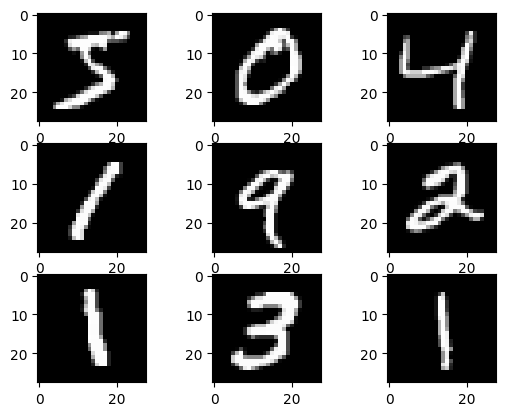

In [8]:
from matplotlib import pyplot
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(X_train[i], cmap=pyplot.get_cmap('gray'))
pyplot.show()

### Бинаризация данных

In [9]:
def to_bw(image):
    for i in range(0, image.shape[0]):
        for j in range(0, image.shape[1]):
            if image[i][j] != 0:
                image[i][j] = 1

In [10]:
(X_train_bw, y_train_bw), (X_test_bw, y_test_bw) = mnist.load_data()

for i in range(0, X_train_bw.shape[0]):
    to_bw(X_train_bw[i])
    
for i in range(0, X_test_bw.shape[0]):
    to_bw(X_test_bw[i])

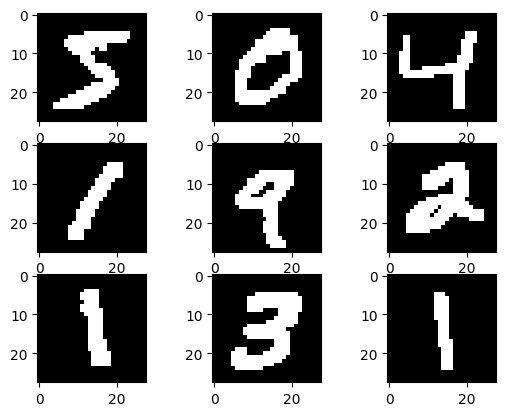

In [11]:
from matplotlib import pyplot
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(X_train_bw[i], cmap=pyplot.get_cmap('gray'))
pyplot.show();

### Преобразование данных
Преобразование картинок в одномерные массивы пикселей
База данных MNIST содержит 60000 для обучения изображений размером 28 на 28 пикселей

In [12]:
X_train = X_train.reshape(60000, 28 * 28)
X_test = X_test.reshape(X_test.shape[0], 28 * 28)

X_train_bw = X_train_bw.reshape(60000, 28 * 28)
X_test_bw = X_test_bw.reshape(X_test_bw.shape[0], 28 * 28)

X_train.shape

(60000, 784)

In [13]:
from sklearn.metrics import log_loss
from matplotlib import pyplot as plt

### Функция обучения по картинкам

In [14]:
def predict_on_images(X_train, y_train, X_test, y_test, dist_func, klimit):
    k_values = np.arange(3, klimit, 2)
    accuracies = []
    
    for k in k_values:
        model = KNN(k = k)
        model.fit(X_train, y_train)
        pred = model.predict(X_test, dist_func)
        acc = log_loss(y_test, pred)
        accuracies.append(acc)
        
    plt.plot(k_values, accuracies)
    plt.xlabel("K")
    plt.ylabel("Log_Loss")

In [15]:
train_start = 5000
train_limit = 10000
test_limit = 100
klimit = 20

In [16]:
def predict_with_different_dist(x_train_curr, y_train_curr, x_test_curr, y_test_curr):
    predict_on_images(
        x_train_curr[train_start:train_limit],
        y_train_curr[train_start:train_limit],
        x_test_curr[0:test_limit],
        y_test_curr[0:test_limit],
        euc_dist,
        klimit
    )
    
    predict_on_images(
        x_train_curr[train_start:train_limit],
        y_train_curr[train_start:train_limit],
        x_test_curr[0:test_limit],
        y_test_curr[0:test_limit],
        euc_dist_sqr,
        klimit
    )
    
    predict_on_images(
        x_train_curr[train_start:train_limit],
        y_train_curr[train_start:train_limit],
        x_test_curr[0:test_limit],
        y_test_curr[0:test_limit],
        abs_dist,
        klimit
    )
    
    predict_on_images(
        x_train_curr[train_start:train_limit],
        y_train_curr[train_start:train_limit],
        x_test_curr[0:test_limit],
        y_test_curr[0:test_limit],
        cheb_dist,
        klimit
    )
    

Предсказание модели для градаций серого

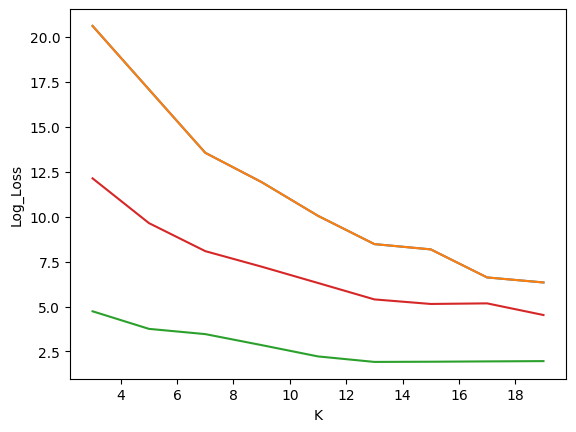

In [17]:
predict_with_different_dist(X_train, y_train, X_test, y_test)

Предсказания для Ч\Б изображений

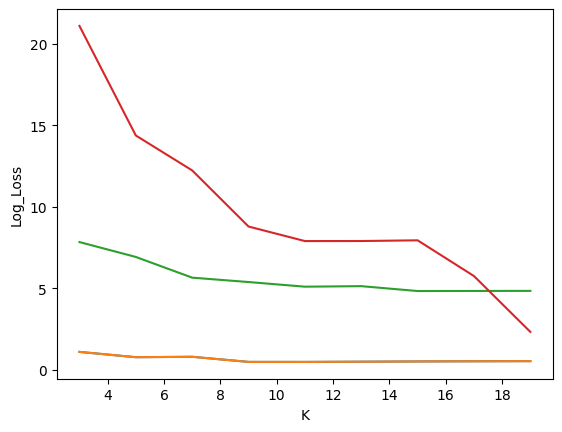

In [18]:
predict_with_different_dist(X_train_bw, y_train_bw, X_test_bw, y_test_bw)

По результатам предсказаний:
* На картинках с градациями серого лучше себя показало модульное расстояние
* На Ч/Б картинках лучше себя показало евклидово расстояние

In [19]:
import random

### Зашумление данных

In [20]:
def gray_noise(pixel):
    result = random.randint(0, 255)
    while result == pixel:
        result = random.randint(0, 255)
    return result

def bw_noise(pixel):
    if pixel == 0:
        return 1
    else:
        return 0

Зашумление картинки либо полностью, либо частично. Также можем зашумлять область со случайным центром и радиусом. Вероятность зашумления пикселя задается вручную в параметре функции.

In [21]:
def noise_image(image, probability, func):
    for x in range(image.shape[0]):
      if random.random() < probability:
        image[x] = func(image[x])


def noise_image_area(image, center, radius, probability, func):
    x_start = 0
    y_start = 0
    x_finish = 28
    y_finish = 28
    
    if center[0] - radius > 0:
        x_start = center[0] - radius
    if center[1] - radius > 0:
        y_start = center[1] - radius
    if center[0] + radius < 28:
        x_finish = center[0] + radius
    if center[1] + radius < 28:
        y_finish = center[1] + radius

    for x in range(x_start, x_finish):
        for y in range(y_start, y_finish):
            if random.random() < probability:
                image[x * 28 + y] = func(x * 28 + y)


def noise_images(images, prob, noise_func):
  for i in range(0, images.shape[0]):
    noise_image(images[i], prob, noise_func)


def noise_images_area(images, prob, noise_func):
  for i in range(0, images.shape[0]):
    noise_image_area(images[i], (random.randint(0, 27), random.randint(0, 27)), random.randint(2, 7), prob, noise_func)

  
def show_images(images):
  images = images.copy().reshape(len(images), 28, 28)
  from matplotlib import pyplot
  for i in range(min(9, len(images))):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(images[i], cmap=pyplot.get_cmap('gray'))
  pyplot.show()

In [22]:
X_train_orig = X_train.copy()
X_test_orig = X_test.copy()

X_train_bw_orig = X_train_bw.copy()
X_test_bw_orig = X_test_bw.copy()

Равномерное зашумление градаций серого

In [23]:
noise_images(X_train, 0.3, gray_noise)
noise_images(X_test, 0.3, gray_noise)

Равномреное зашумление Ч/Б

In [24]:
noise_images(X_train_bw, 0.3, bw_noise)
noise_images(X_test_bw, 0.3, bw_noise)

Примеры равномерно зашумленных изображений

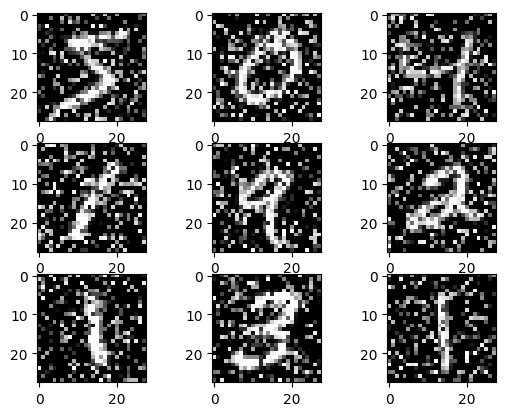

In [25]:
show_images(X_train)

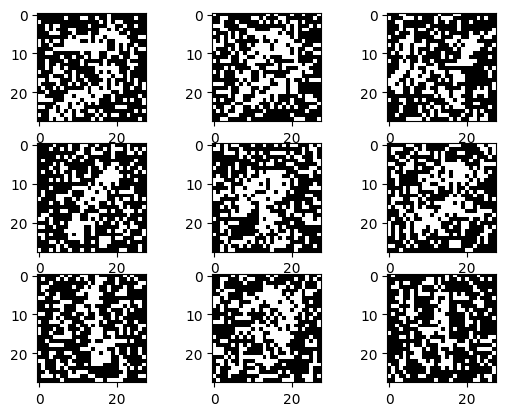

In [26]:
show_images(X_train_bw)

Предсказание для равномерно зашумленных градаций серого

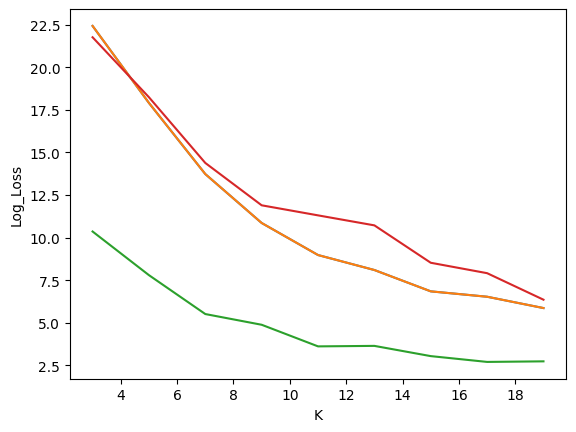

In [27]:
predict_with_different_dist(X_train, y_train, X_test, y_test)

Предсказание для равномерно зашумленных Ч/Б изображений

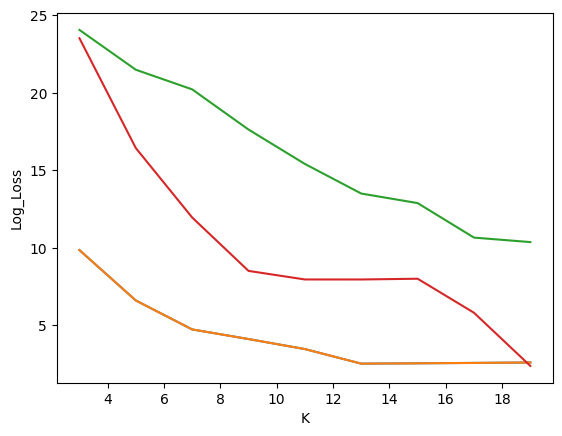

In [28]:
predict_with_different_dist(X_train_bw, y_train_bw, X_test_bw, y_test_bw)

По результатам предсказаний:
* Для градаций серого модульное расстояние также лучше, но точность стала хуже, чем у не зашумленных
* Для Ч/Б евклидово расстояние также лучше, но точность стала хуже, чем у не зашумленных

In [29]:
X_train = X_train_orig.copy()
X_test = X_test_orig.copy()

X_train_bw = X_train_bw_orig.copy()
X_test_bw = X_test_bw_orig.copy()

Неравномерное зашумление градаций серого

In [30]:
noise_images_area(X_train, 0.3, gray_noise)
noise_images_area(X_test, 0.3, gray_noise)

Неравномерное зашумление Ч/Б

In [31]:
noise_images_area(X_train_bw, 0.3, bw_noise)
noise_images_area(X_test_bw, 0.3, bw_noise)

Примеры неравномерно зашумленных изображений

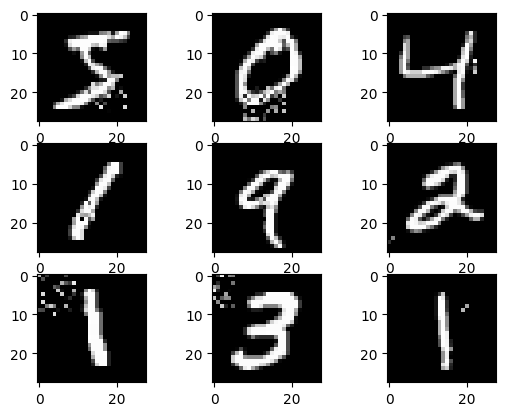

In [32]:
show_images(X_train)

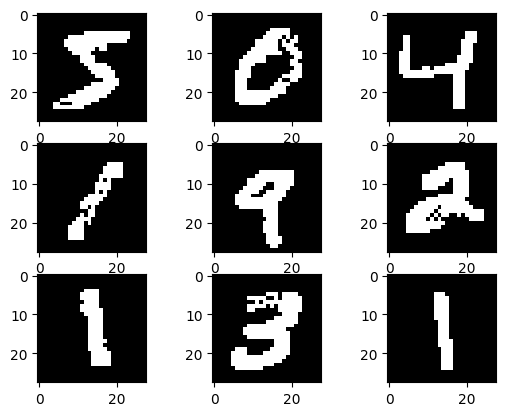

In [33]:
show_images(X_train_bw)

Предсказания для неравномерно зашумленных градаций серого

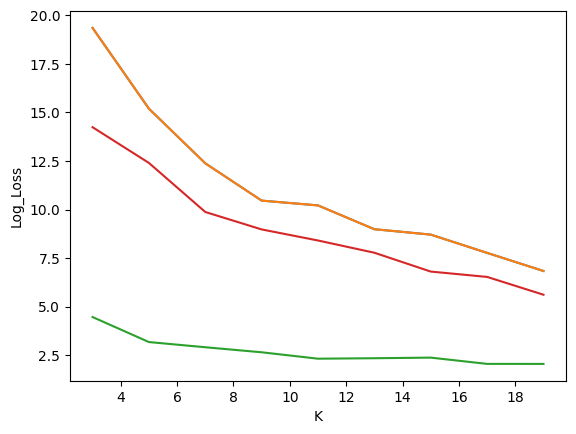

In [34]:
predict_with_different_dist(X_train, y_train, X_test, y_test)

Предсказания для неравномерно зашумленных Ч/Б

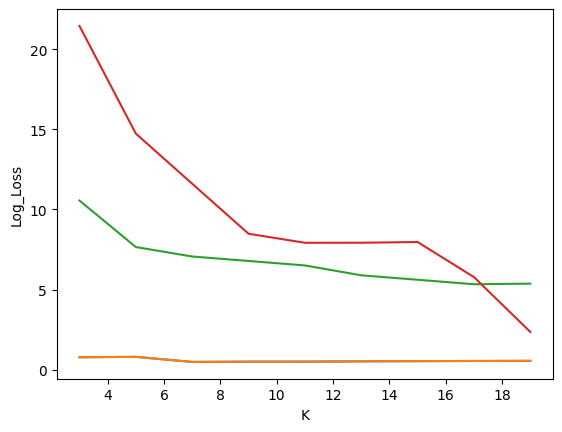

In [35]:
predict_with_different_dist(X_train_bw, y_train_bw, X_test_bw, y_test_bw)

По результатам предсказаний:
* Для градаций серого модульное расстояние также лучше, но точность стала хуже, чем у не зашумленных
* Для Ч/Б евклидово расстояние также лучше, но точность стала хуже, чем у не зашумленных

## kNN- и ODIN- идентификаторы

In [36]:
X_train_orig.shape

(60000, 784)

In [37]:
def knn(images, distf, outcasts, k_value):
    result = 0
    
    for img in images:
      tmp_list = images.copy()
      tmp_list.remove(img)
      tmp_list.sort(key=lambda img1: distf(np.array(img), np.array(img1))) 
      dists = [tmp_list[:k_value]]
      
      # print("Min dist = ", np.min(dists))
      # print("Max dist = ", np.max(dists))
      # print("Mean dist = ", np.mean(dists))

      if np.mean(dists) > 50:
          outcasts.append(img)
          result += 1
    
    return result

In [38]:
def odin(images, distf, outcasts, limit=4, num_occurences=1):
  candidates = []
  
  for img in images:
    tmp_list = images.copy()
    tmp_list.remove(img)
    tmp_list.sort(key=lambda img1: distf(np.array(img), np.array(img1)))
    candidates.append(tmp_list[:limit])
    
    merged_candidates = []
    for img_list in candidates:
      for img in img_list:
        merged_candidates.append(img)
    
  result = 0
  for img in images:
    if merged_candidates.count(img) <= num_occurences:
      outcasts.append(img)
      result += 1
    
  return result

In [39]:
def show_images_outliers(images):
  images = images.copy().reshape(len(images), 28, 28)
  from matplotlib import pyplot
  pyplot.subplots(figsize=(28, 28))
  for i in range(len(images)):
    pyplot.subplot(15, 6, 1 + i)
    pyplot.imshow(images[i], cmap=pyplot.get_cmap('gray'))
  pyplot.show()

In [40]:
X_train_noised = X_train_orig.copy()

In [41]:
noise_images(X_train_noised, 0.3, gray_noise)

In [42]:
test_set = X_train_orig[1000:2000].tolist().copy()

### Поиск выбросов в изначальной выборке

ODIN

In [43]:
outcasts = []
odin(test_set, euc_dist, outcasts, 100, 20)

25

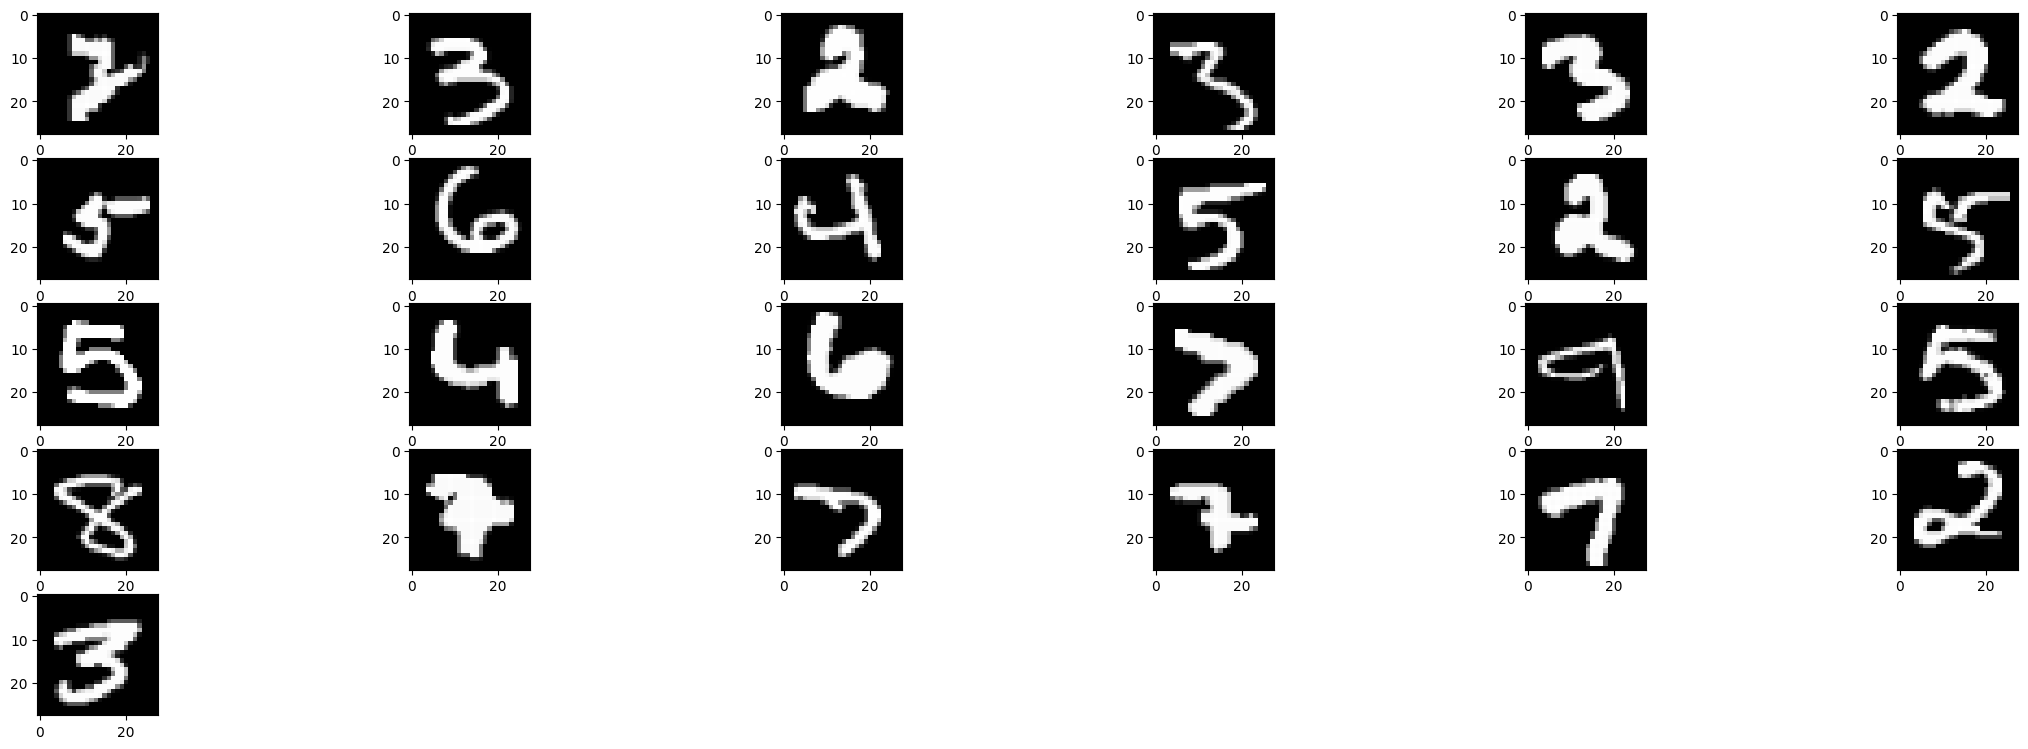

In [44]:
show_images_outliers(np.array(outcasts))

kNN

In [45]:
outcasts = []
knn(test_set, euc_dist, outcasts, 3)

81

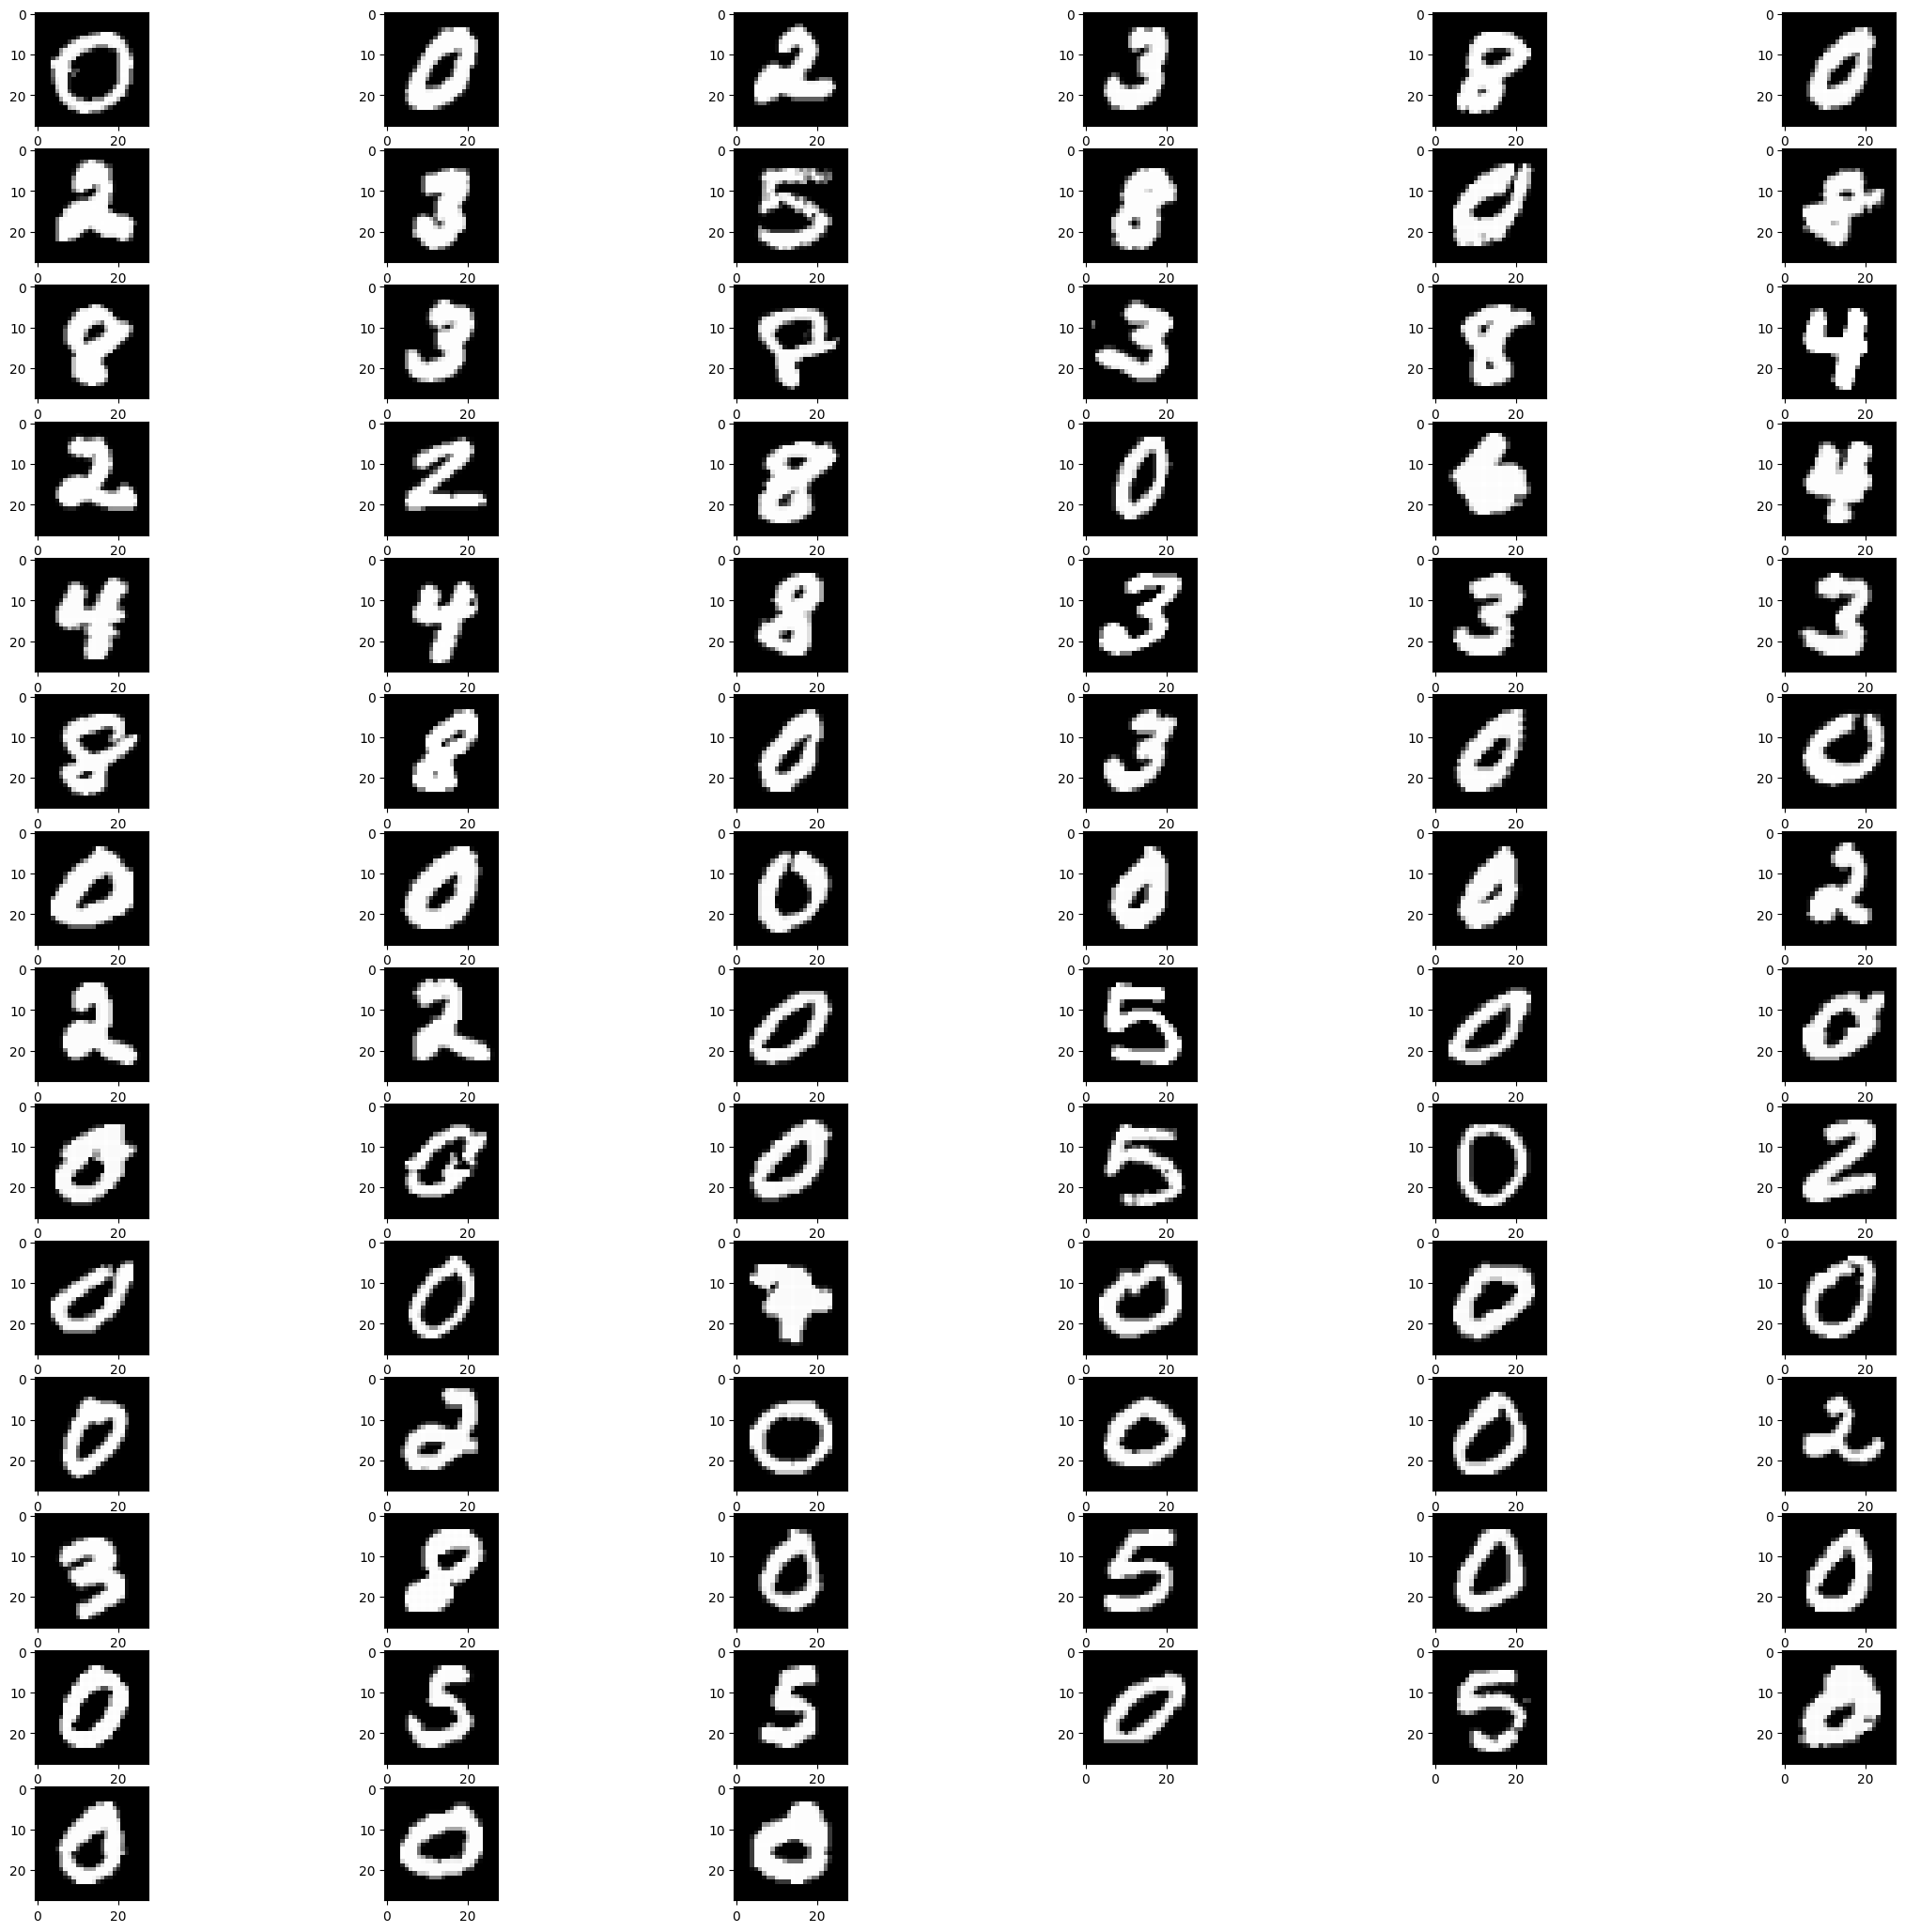

In [46]:
show_images_outliers(np.array(outcasts))

Результаты на изначальной выборке:
* ODIN: Число выбросов - 25
* kNN: Число выбросов - 81

Выброс - черный квадрат

In [47]:
test_set.append([255] * 784)

ODIN

In [48]:
outcasts = []
odin(test_set, euc_dist, outcasts, 100, 20)

24

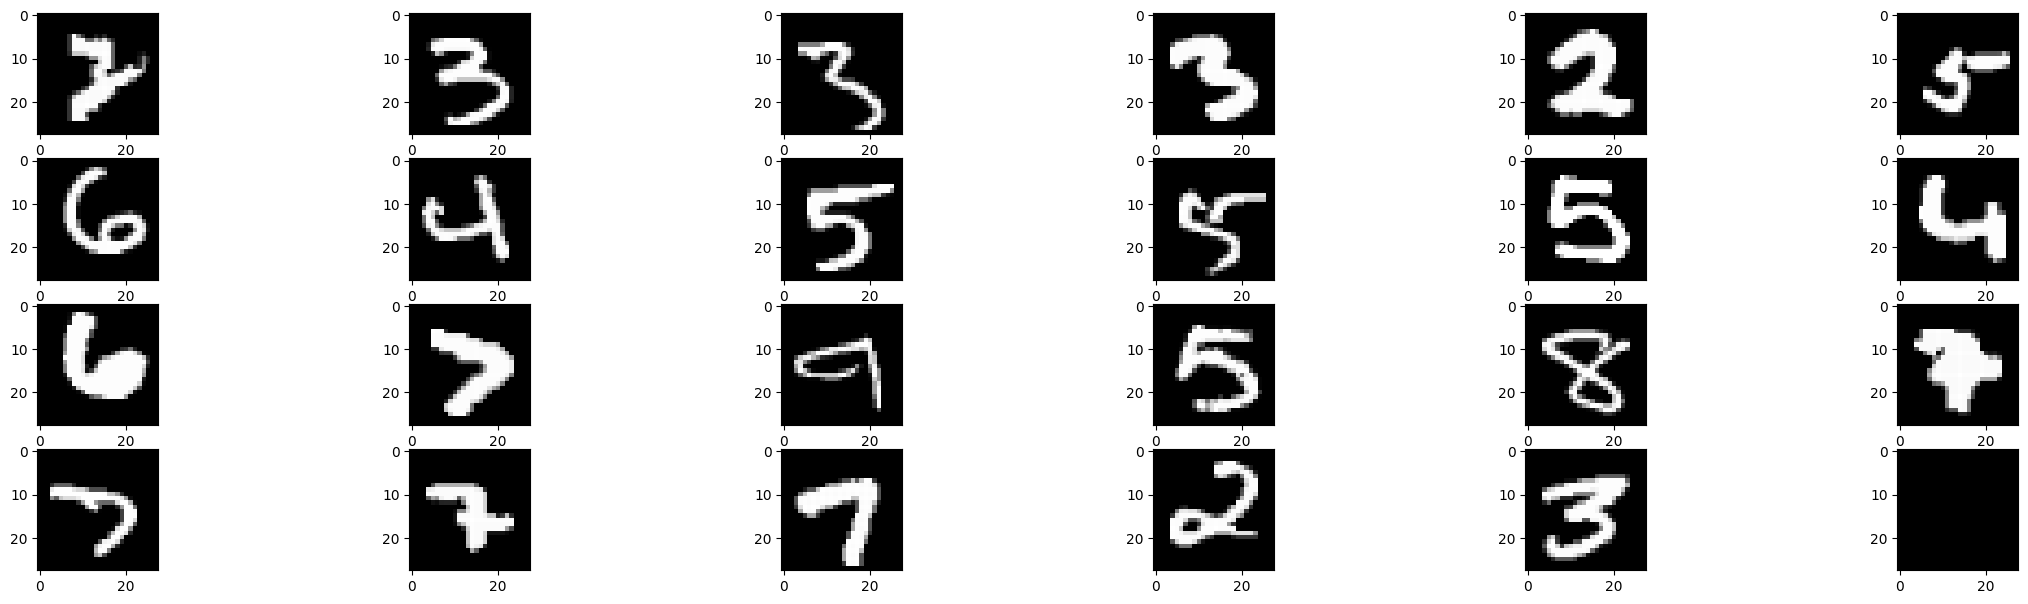

In [49]:
show_images_outliers(np.array(outcasts))

kNN

In [50]:
outcasts = []
knn(test_set, euc_dist, outcasts, 3)

82

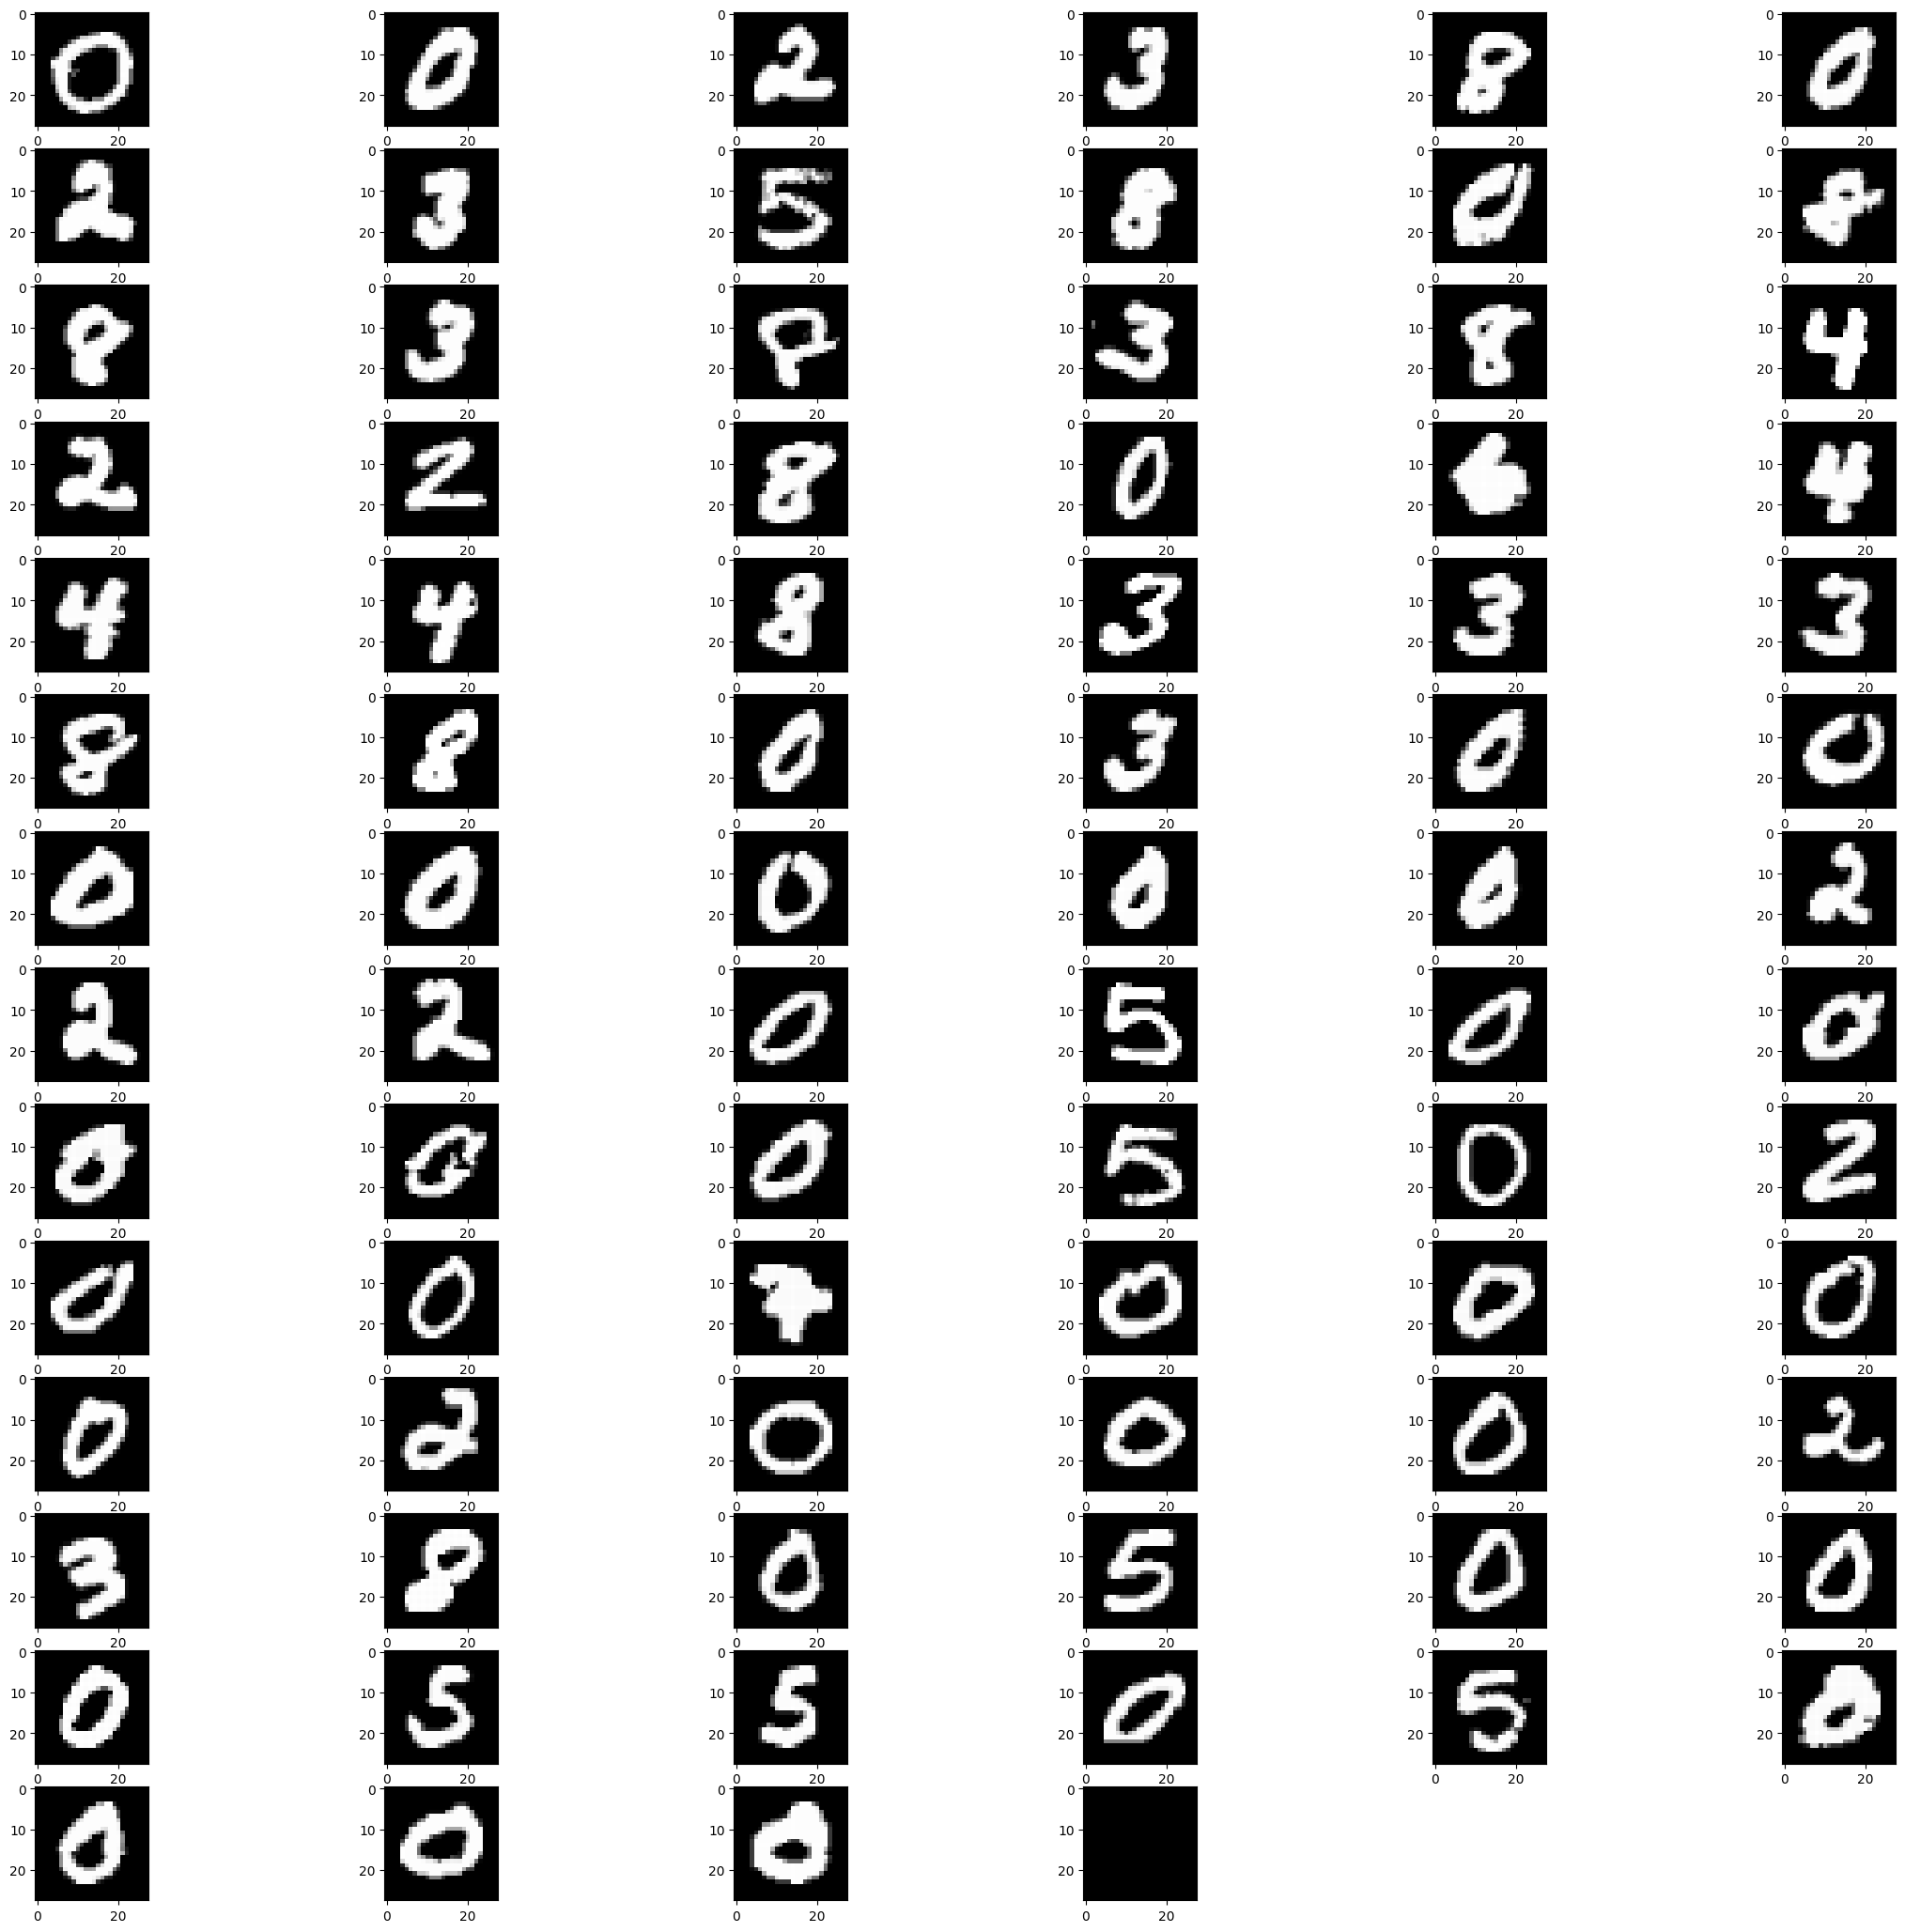

In [51]:
show_images_outliers(np.array(outcasts))

Результаты на выборке с черным квадратом:
* ODIN: Число выбросов - 24
* kNN: Число выбросов - 82

Оба подхода нашли черный квадрат и идентифицировали его как выброс.

Выбросы - зашумленные изображения

In [52]:
test_set.extend(X_train_noised[1000:1050].tolist())

ODIN

In [53]:
outcasts = []
odin(test_set, euc_dist, outcasts, 100, 20)

72

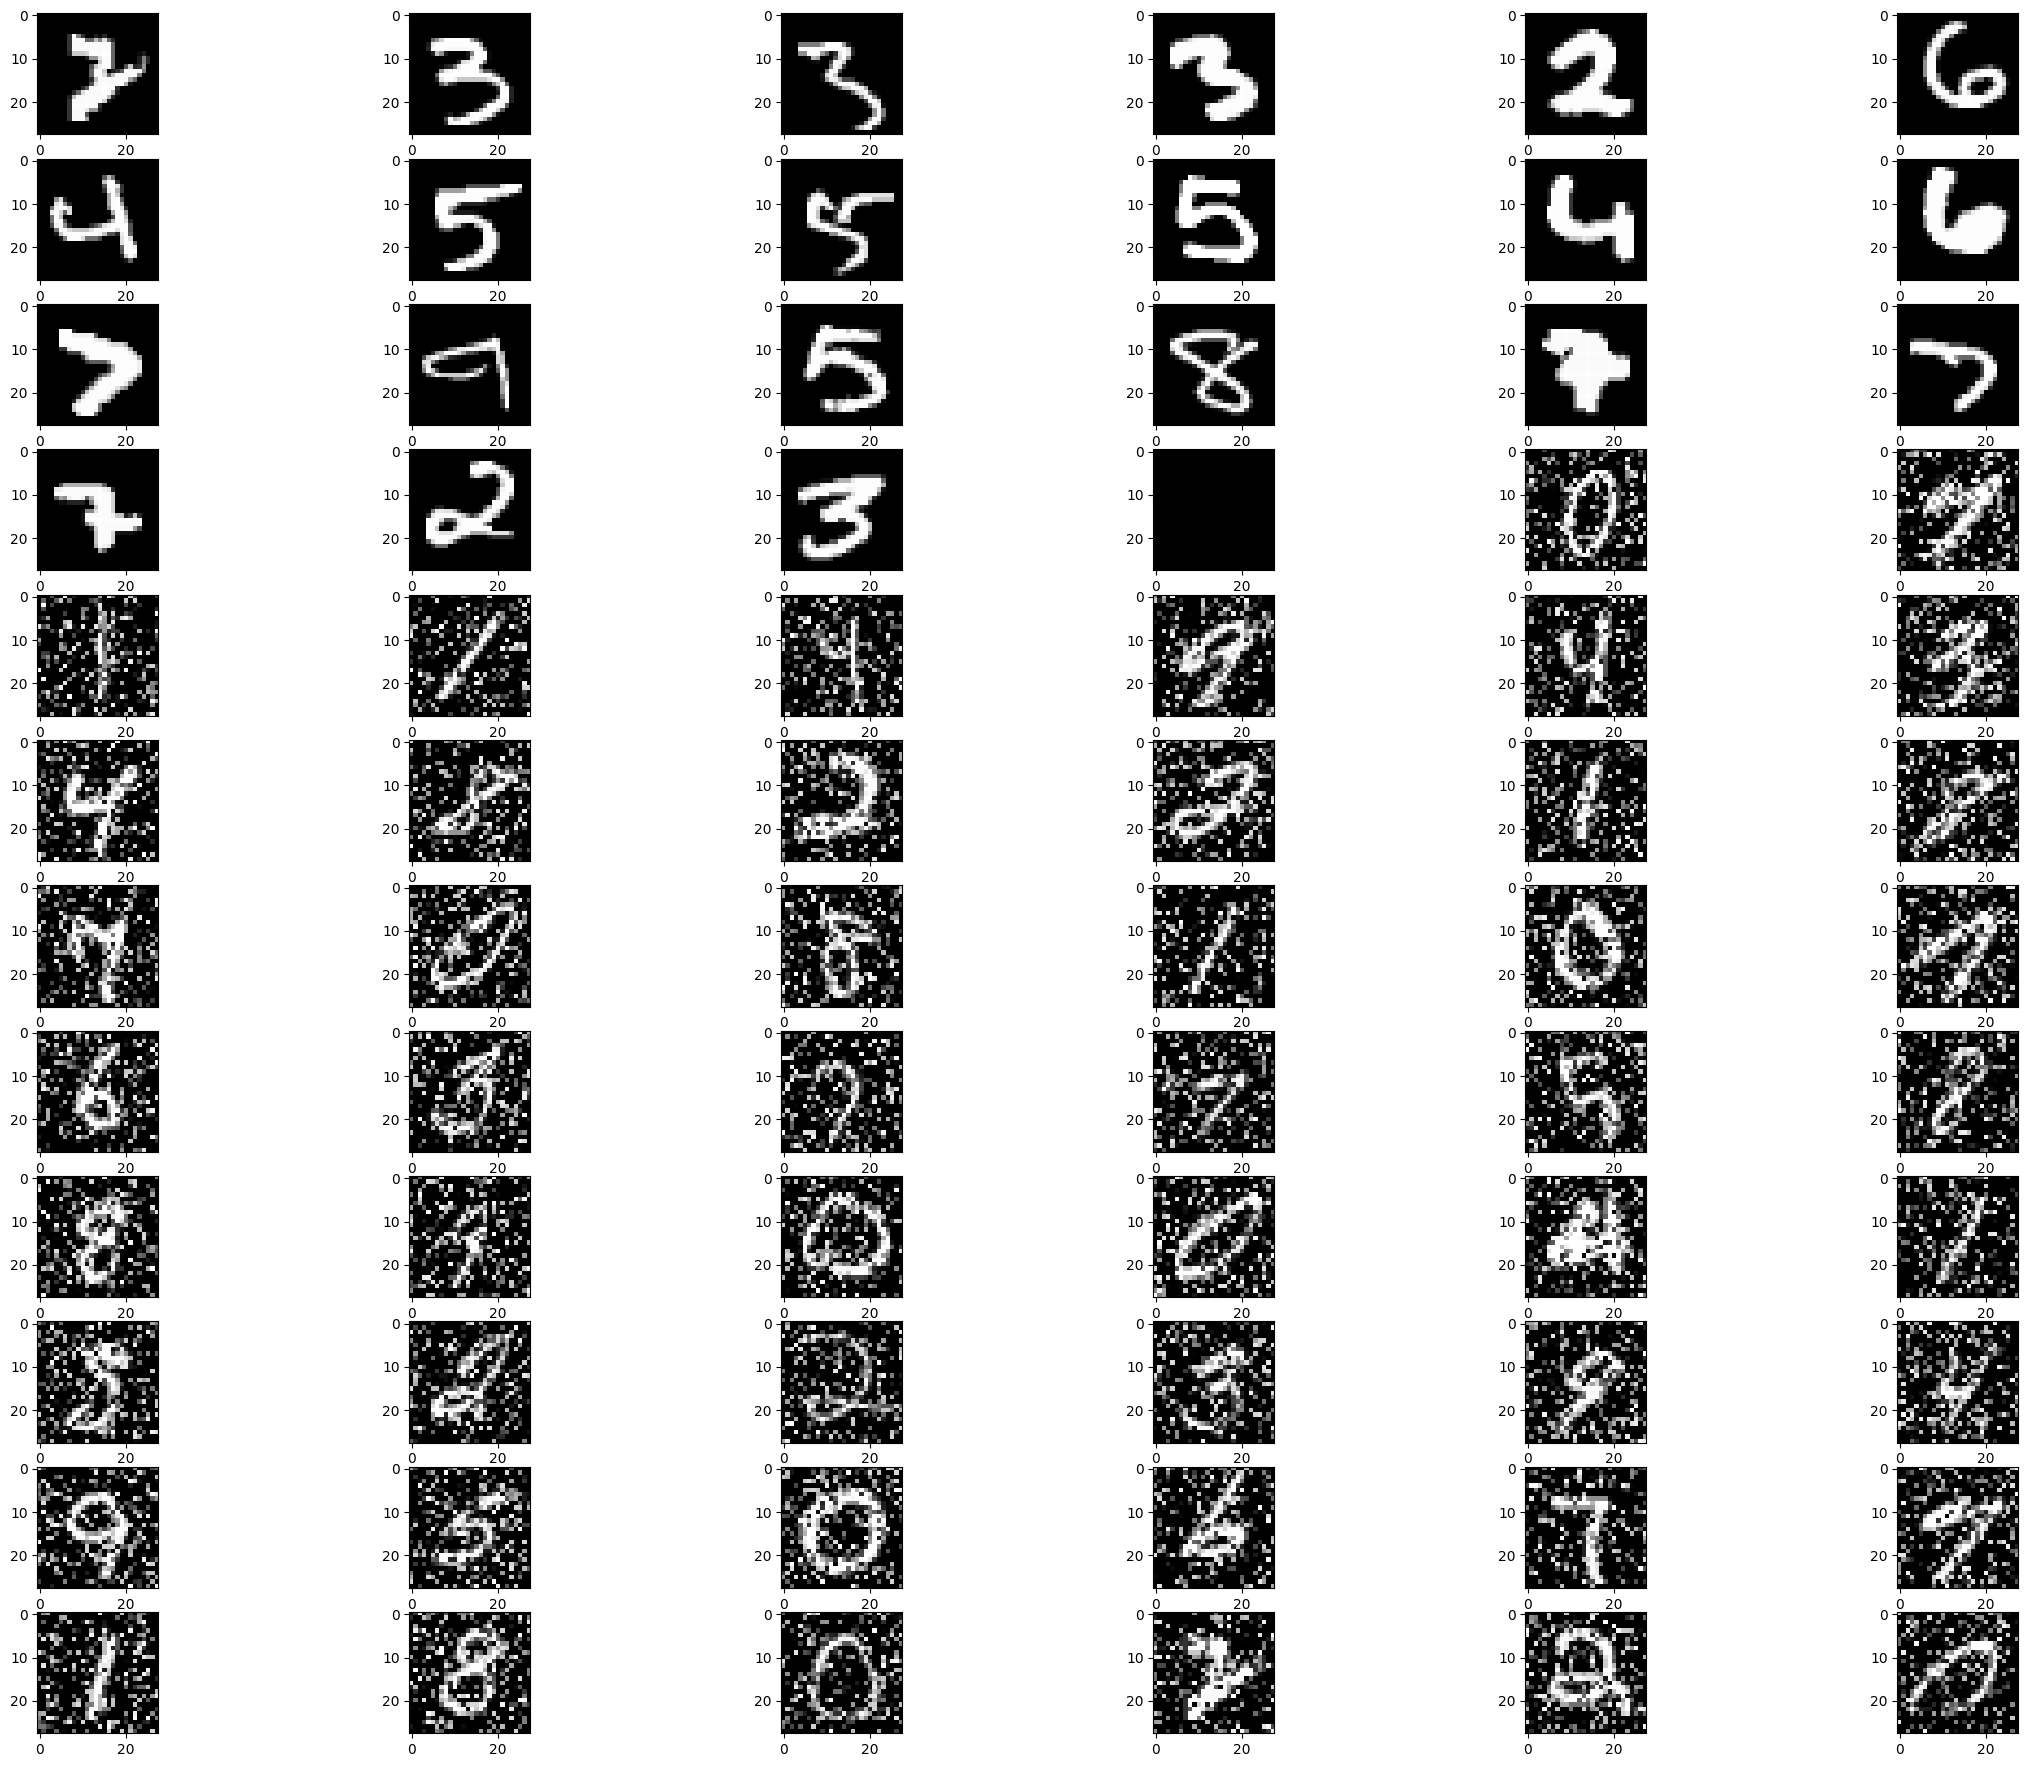

In [54]:
show_images_outliers(np.array(outcasts))

kNN

In [55]:
outcasts = []
knn(test_set, euc_dist, outcasts, 3)

83

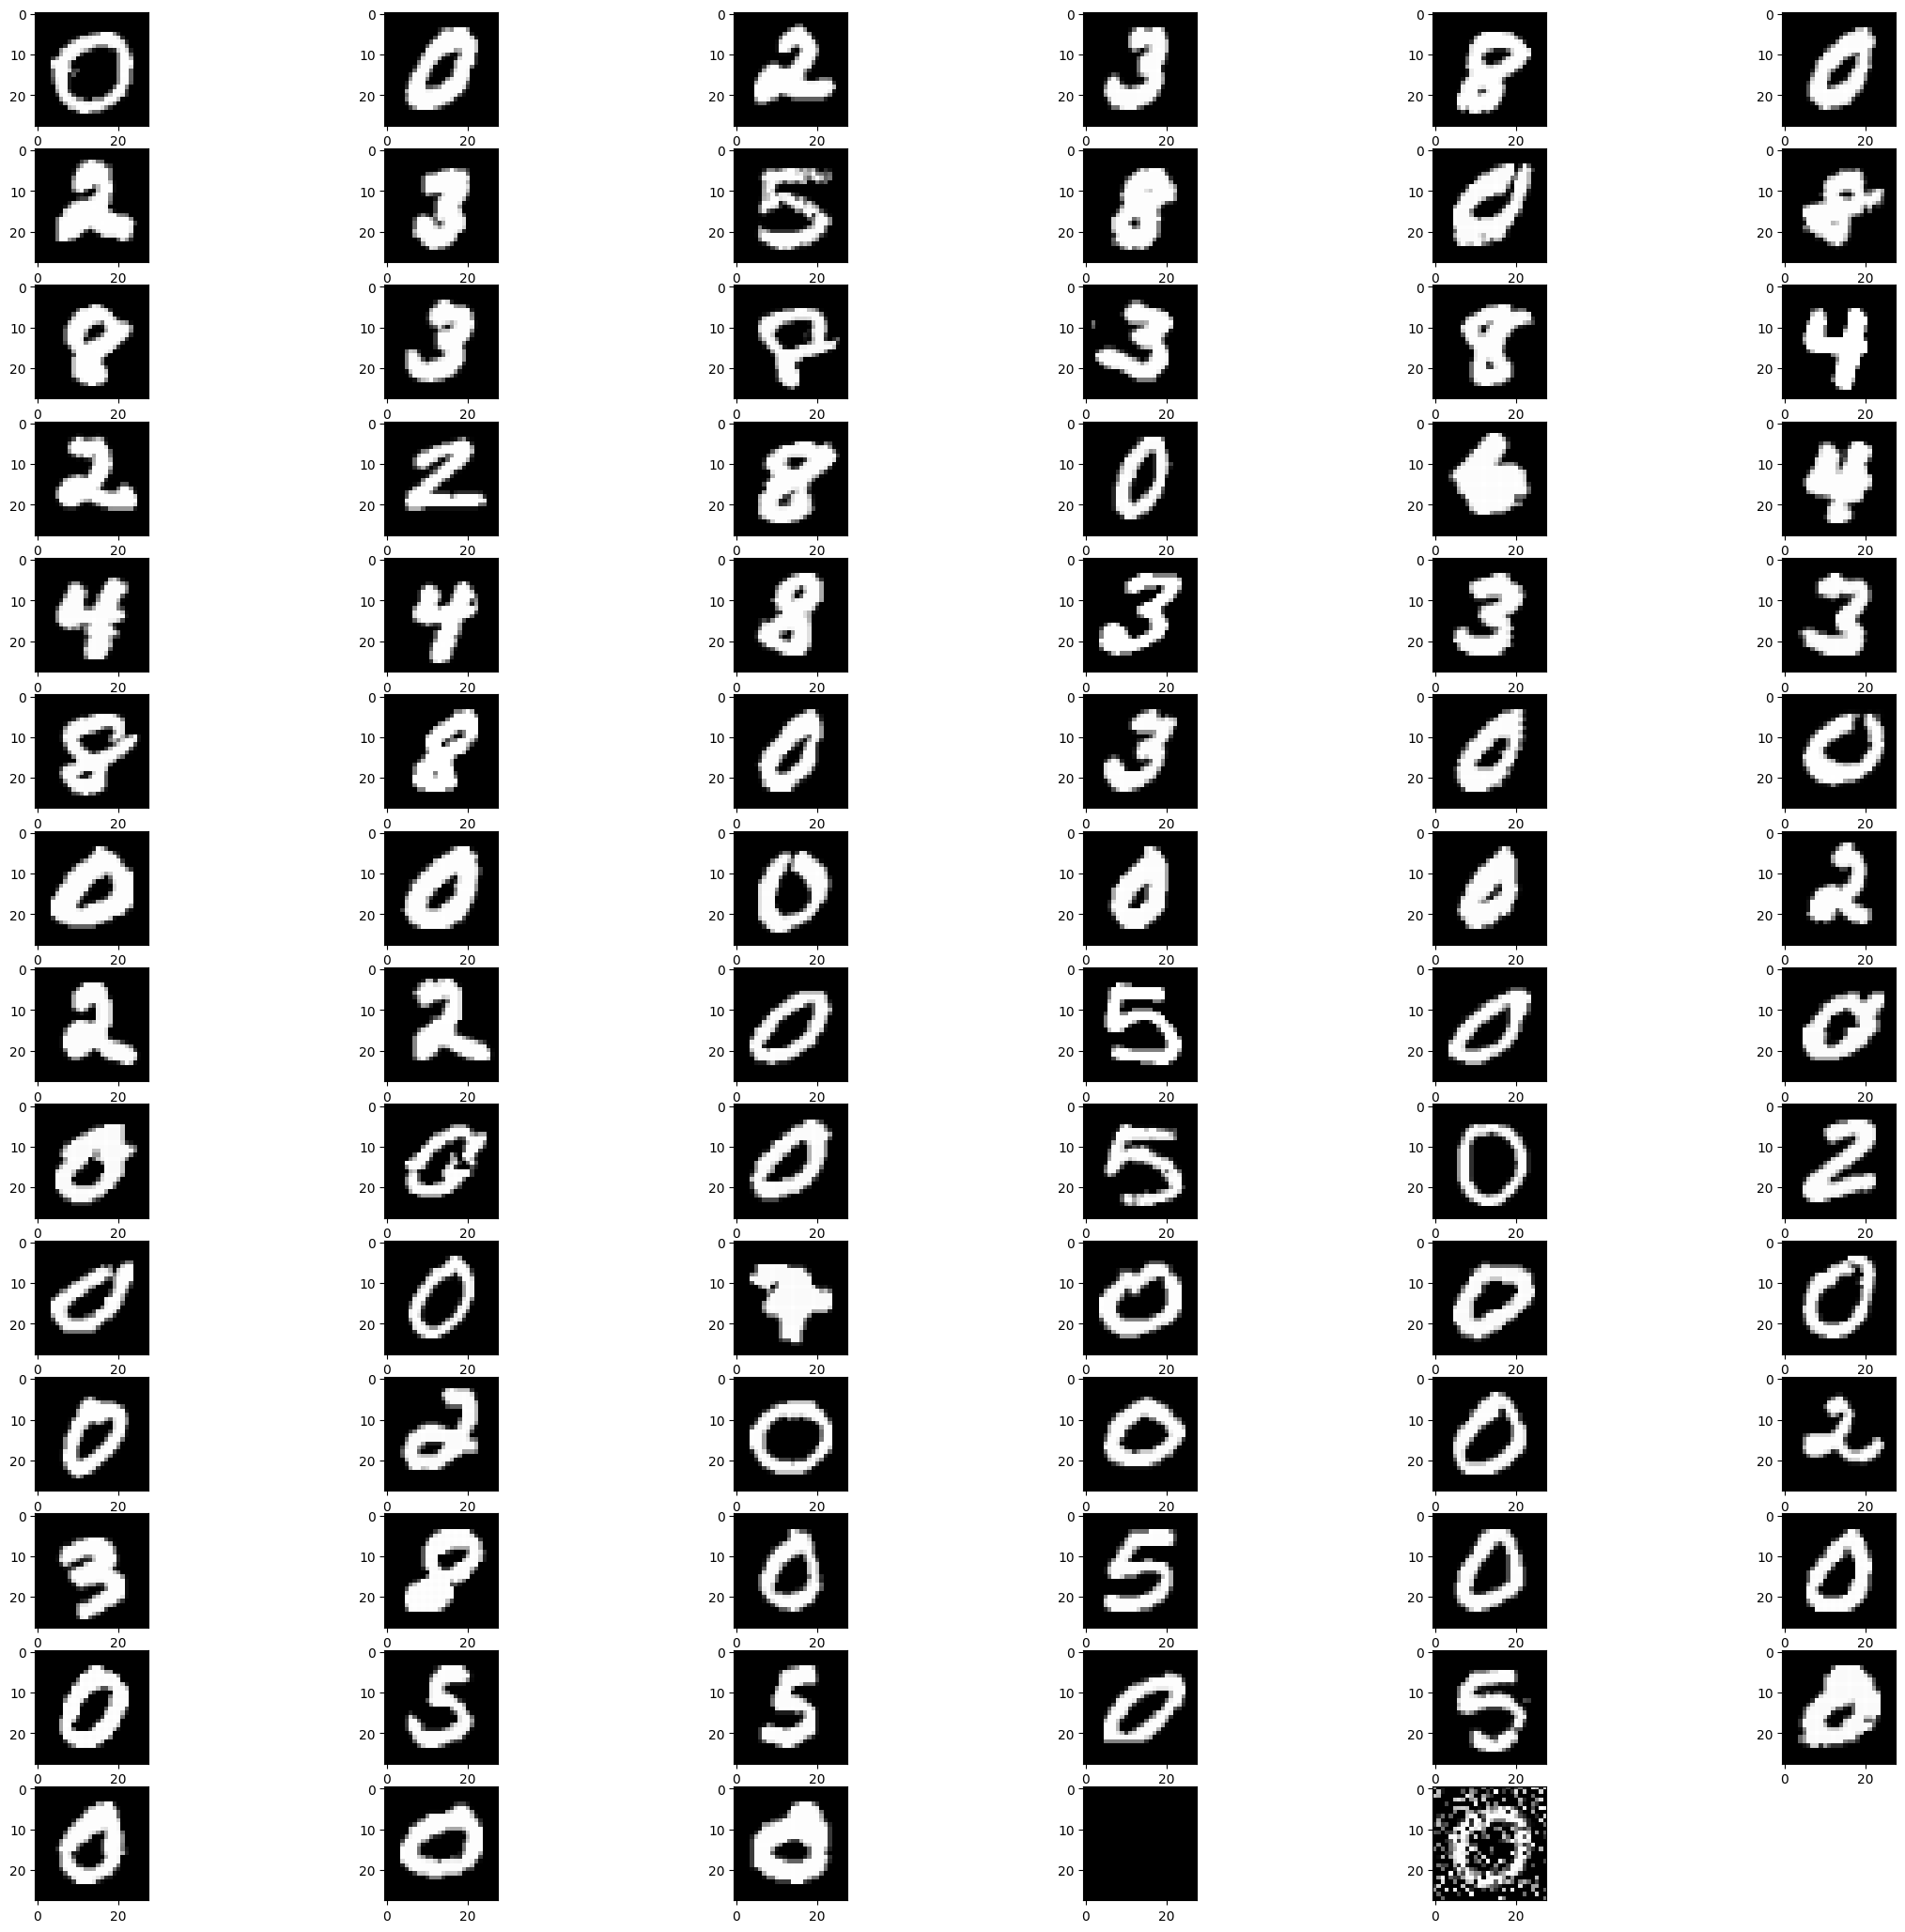

In [56]:
show_images_outliers(np.array(outcasts))

Результаты на выборке с черным квадратом и зашумленными изображениями:
* ODIN: Число выбросов - 71
* kNN: Число выбросов - 84

ODIN в отличие от kNN нашел больше зашумленных выбросов, в то время как kNN нашел только один. 